<div id="Import Libraries">

# **Importing Libraries** 

In [79]:
import os
import gc
import cv2
import json
import time
import shutil
import numpy as np
from tqdm import tqdm
import mediapipe as mp
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor
from IPython.display import clear_output, FileLink
import keras
from PIL import Image, ImageOps

In [146]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [169]:
RESOURCES_DIR = "resources/"
DATA_DIR = "data/asl_words_video/"
VIDEOS_DIR = "data/asl_words_video/videos/"
PROCESSED_DIR = "data/asl_words_video/processed/"
PROCESSED_VIDEOS_DIR = "data/asl_words_video/processed/videos/"
MODEL_DIR = "models/asl_words_classifier/"

In [170]:
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

---

<div id="Label Filtering">

# **Label Filtering**
**<h2>(Done Once)**

In [83]:
import fasttext
import fasttext.util

# fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model(RESOURCES_DIR + "/cc.en.300.bin")

In [84]:
with open(DATA_DIR + "/WLASL_v0.3.json", "r") as json_file:
    orig_data = json.load(json_file)

In [85]:
list_labels = list()
for i in range(len(orig_data)):
    gloss = orig_data[i]["gloss"]
    list_labels.append(gloss)
labels = list(np.unique(list_labels))

In [86]:
encoded_labels = {label: ft.get_word_vector(label) for label in labels}

In [87]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [88]:
chosen_words = [
    "hello",
    "goodbye",
    "thank you",
    "sorry",
    "yes",
    "no",
    "stop",
    "go",
    "left",
    "right",
    "help",
]

In [89]:
WORDS_SIMILARITY_THRESHOLD = 0.6
similar_words_set = set()
popular_word_vectors = [ft.get_word_vector(word) for word in chosen_words]

for label, label_vector in encoded_labels.items():
    for popular_word_vector in popular_word_vectors:
        similarity_score = cosine_similarity(popular_word_vector, label_vector)
        if similarity_score > WORDS_SIMILARITY_THRESHOLD:
            similar_words_set.add(label)

similar_words_list = list(similar_words_set)

In [90]:
encoded_filtered_labels = {
    label: ft.get_word_vector(label) for label in similar_words_list
}
np.savez_compressed(PROCESSED_DIR + "filtered_labels.npz", **encoded_filtered_labels)

In [91]:
with open(PROCESSED_DIR + "filtered_labels.txt", "w") as file:
    for label in similar_words_list:
        file.write(label + "\n")

---

<div id="Data_Preparation">
    
# **Data Preparation**
**<h2>(Done Once)**

In [92]:
with open(DATA_DIR + "/WLASL_v0.3.json", "r") as json_file:
    all_data = json.load(json_file)

In [93]:
labels = []
with open(PROCESSED_DIR + "filtered_labels.txt", "r") as file:
    labels = file.read().splitlines()

In [94]:
data = []  # formatted data

for i in tqdm(range(len(all_data)), ncols=100):
    # for i in tqdm(range(10), ncols=100):
    gloss = all_data[i]["gloss"]

    if gloss not in labels:
        continue

    instances = all_data[i]["instances"]
    for instance in instances:
        video_id = instance["video_id"]
        if os.path.exists(os.path.join(VIDEOS_DIR, f"{video_id}.mp4")) == False:
            continue

        frame_start = instance["frame_start"]
        frame_end = instance["frame_end"]
        split = instance["split"]
        data.append(
            {
                "gloss": gloss,
                "video_id": video_id,
                "frame_start": frame_start,
                "frame_end": frame_end,
                "split": split,
            }
        )

100%|███████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 411448.30it/s]


In [95]:
with open(PROCESSED_DIR + "/WLASL_parsed_data.json", "w") as json_file:
    json.dump(data, json_file, indent=4)

---

<div id="Videos_Standardization">

# **Videos Standardization**

In [97]:
IMAGE_SIZE = 224
PADDING_COLOUR = [0, 255, 0]
CROP_MARGIN = 50

In [98]:
def resize_image(image, height=IMAGE_SIZE, width=IMAGE_SIZE):
    image = Image.fromarray(image)
    image.thumbnail((width, height))
    image = np.asarray(image)
    y_border = max(height - image.shape[0], 0)
    x_border = max(width - image.shape[1], 0)
    top = y_border
    bottom = 0
    left = x_border
    right = 0
    image = cv2.copyMakeBorder(
        image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=PADDING_COLOUR
    )
    return image

In [99]:
hands = mp.solutions.hands.Hands()


def get_2hands_coord(image_rgb):
    result = hands.process(image_rgb)
    height, width, _ = image_rgb.shape
    # Check if hands are detected

    left_x = width
    right_x = 0
    bottom_y = height
    top_y = 0

    if result.multi_hand_landmarks:
        x_coordinates = []
        y_coordinates = []
        for hand_landmarks in result.multi_hand_landmarks:
            # Draw landmarks on the frame
            # mp.solutions.drawing_utils.draw_landmarks(image_rgb, hand_landmarks, mp.solutions.hands.HAND_CONNECTIONS)

            # Get the top left corner of the detected hand's bounding box.
            # x_coordinates = []
            # y_coordinates = []
            for landmark in hand_landmarks.landmark:
                x_coordinates.append(landmark.x)
                y_coordinates.append(landmark.y)

        left_x = int(min(x_coordinates) * width)
        right_x = int(max(x_coordinates) * width)
        bottom_y = int(min(y_coordinates) * height)
        top_y = int(max(y_coordinates) * height)

    return (left_x, right_x, top_y, bottom_y)

I0000 00:00:1724998847.337997   86912 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M3 Pro


W0000 00:00:1724998847.346096  256660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1724998847.352559  256665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [100]:
def check_start_end_frames(video_cap, start_frame=1, end_frame=-1):
    # if the starting is 0
    if start_frame <= 1:
        start_frame = 1

    # if the video is precropped
    elif start_frame > int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT)):
        start_frame = 1
        end_frame = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # if the final frame was not given (-1)
    if end_frame < 0:
        end_frame = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))

    return (start_frame, end_frame)

In [101]:
def get_video_hands_coord(video_path, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(video_path)

    (start_frame, end_frame) = check_start_end_frames(cap, start_frame, end_frame)

    # num_landmarks = HAND_NUM * 2 + POSE_NUM + FACE_NUM
    # all_frame_landmarks = np.zeros((end_frame - start_frame + 1, num_landmarks, 3))
    frame_index = 1
    list_left_x = []
    list_right_x = []
    list_top_y = []
    list_bottom_y = []

    while cap.isOpened() and frame_index <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_index >= start_frame:
            frame.flags.writeable = False
            # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            (left_x, right_x, top_y, bottom_y) = get_2hands_coord(frame)

            list_left_x.append(left_x)
            list_right_x.append(right_x)
            list_top_y.append(top_y)
            list_bottom_y.append(bottom_y)

        frame_index += 1

    cap.release()
    hands.reset()

    return (min(list_left_x), max(list_right_x), max(list_top_y), min(list_bottom_y))

In [135]:
def crop_image(image, left_x, right_x, top_y, bottom_y):
    orig_height, orig_width, _ = image.shape

    if left_x > right_x:
        tmp = left_x
        left_x = right_x
        right_x = tmp
    if bottom_y > top_y:
        tmp = top_y
        top_y = bottom_y
        bottom_y = tmp

    left_x = max(left_x - CROP_MARGIN, 0)
    right_x = min(right_x + CROP_MARGIN, orig_width)
    bottom_y = max(bottom_y - CROP_MARGIN, 0)
    top_y = min(top_y + CROP_MARGIN, orig_height)

    cropped_image = image[bottom_y:top_y, left_x:right_x]

    cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)

    return cropped_image

In [116]:
def load_video(video_path, start_frame=1, end_frame=-1):
    cap = cv2.VideoCapture(video_path)
    frames = []

    (start_frame, end_frame) = check_start_end_frames(cap, start_frame, end_frame)

    (left_x, right_x, top_y, bottom_y) = get_video_hands_coord(
        video_path, start_frame, end_frame
    )

    frame_index = 1
    while cap.isOpened() and frame_index <= end_frame:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_index >= start_frame:
            # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = crop_image(frame, left_x, right_x, top_y, bottom_y)
            frame = resize_image(frame)

            # frame = frame[:, :, [2, 1, 0]]

            frames.append(frame)

            frame_index += 1
    cap.release()

    return np.array(frames)

---

<div id="Features_Extraction">

# **Features Extraction**

In [104]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMAGE_SIZE, IMAGE_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

---

<div id="Data_Loading">
    
# **Data Loading**

In [154]:
BATCH_SIZE = 5
EPOCHS = 50

MAX_SEQ_LENGTH = 50
NUM_FEATURES = 2048

In [106]:
with open(PROCESSED_DIR + "WLASL_parsed_data.json", "r") as json_file:
    data = json.load(json_file)

In [138]:
labels_dict = np.load(PROCESSED_DIR + "filtered_labels.npz", allow_pickle=True)

In [159]:
def prepare_all_videos(data, split):
    split_data = [i for i in data if i["split"] == split]

    num_samples = len(split_data)

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denotin g if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )
    video_labels = []

    for idx in range(num_samples):
        video_label = data[idx]["gloss"]

        video_labels.append(video_label)

        video_id = data[idx]["video_id"]
        video_path = os.path.join(VIDEOS_DIR, f"{video_id}.mp4")
        start = data[idx]["frame_start"]
        end = data[idx]["frame_end"]

        frames = load_video(video_path, start_frame=start, end_frame=end)
        if len(frames) > MAX_SEQ_LENGTH:
            cropped_frames = len(frames) - MAX_SEQ_LENGTH
            frames = frames[
                (cropped_frames // 2) : (cropped_frames // 2 + MAX_SEQ_LENGTH)
            ]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(
            shape=(
                1,
                MAX_SEQ_LENGTH,
            ),
            dtype="bool",
        )
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        length = len(frames)
        for i, frame in enumerate(frames):
            temp_frame_features[0, i, :] = feature_extractor.predict(
                frame[None, ...],
                verbose=0,
            )
        temp_frame_mask[0, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()
        # break

    return (frame_features, frame_masks), video_labels

In [197]:
X_train, y_train = prepare_all_videos(data, "train")

print(f"Frame features in train set: {X_train[0].shape}")
print(f"Frame masks in train set: {X_train[1].shape}")

W0000 00:00:1725006318.104889  256658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725006318.111079  256658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725006322.124308  256657 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725006322.128009  256657 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725006325.574997  256655 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725006325.578487  256655 inference_feedback_manager.cc:114] Feedback manager 

Frame features in train set: (92, 50, 2048)
Frame masks in train set: (92, 50)


In [198]:
X_val, y_val = prepare_all_videos(data, "val")

print(f"Frame features in train set: {X_val[0].shape}")
print(f"Frame masks in train set: {X_val[1].shape}")

W0000 00:00:1725006714.387488  256663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725006714.391738  256663 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725006718.228890  256666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725006718.232291  256666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725006721.919806  256665 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725006721.923347  256665 inference_feedback_manager.cc:114] Feedback manager 

Frame features in train set: (23, 50, 2048)
Frame masks in train set: (23, 50)


In [199]:
X_test, y_test = prepare_all_videos(data, "test")

print(f"Frame features in train set: {X_test[0].shape}")
print(f"Frame masks in train set: {X_test[1].shape}")

W0000 00:00:1725006817.384521  256664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725006817.387748  256664 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725006821.282837  256658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725006821.285829  256656 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725006824.810076  256655 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1725006824.813128  256655 inference_feedback_manager.cc:114] Feedback manager 

Frame features in train set: (17, 50, 2048)
Frame masks in train set: (17, 50)


---

<div id="Label_Encoding">
    
# **Label Encoding**

In [200]:
labels = []
with open(PROCESSED_DIR + "filtered_labels.txt", "r") as file:
    labels = file.read().splitlines()

In [201]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(labels)
)
print(label_processor.get_vocabulary())

['anyway', 'assist', 'go', 'goodbye', 'guess', 'hello', 'help', 'left', 'need', 'no', 'right', 'sorry', 'stop', 'suppose', 'thank you', 'there', 'to', 'yes']


In [204]:
y_train_2 = keras.ops.convert_to_numpy(label_processor(list(y_train)))
y_val_2 = keras.ops.convert_to_numpy(label_processor(list(y_val)))
y_test_2 = keras.ops.convert_to_numpy(label_processor(list(y_test)))


In [205]:
y_train_2.shape

(92,)

In [163]:
y_train_1 = np.array([labels_dict[label] for label in y_train])
y_val_1 = np.array([labels_dict[label] for label in y_val])
y_test_1 = np.array([labels_dict[label] for label in y_test])

---

<div id="Model_Building">
    
# **Model Building**

In [206]:
# Utility for our sequence model.
def get_sequence_model_1():

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(512, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(512)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(512, activation="relu")(x)
    output = keras.layers.Dense(300, activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    adam = tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-06,
        amsgrad=False,
        name="Adam",
    )

    rnn_model.compile(
        loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy"]
    )
    return rnn_model

In [208]:
def get_sequence_model_2():

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(100, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(50)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(50, activation="relu")(x)
    output = keras.layers.Dense(len(label_processor.get_vocabulary()), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    adam = tf.keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-06,
        amsgrad=False,
        name="Adam",
    )

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=adam, metrics=["accuracy"]
    )
    return rnn_model

In [216]:
# Utility for running experiments.
def run_experiment(model, train_data, train_label, val_data, val_label, test_data, test_label, model_save_name):
    filepath = MODEL_DIR + model_save_name
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    history = model.fit(
        [train_data[0], train_data[1]],
        train_label,
        validation_data=([val_data[0], val_data[1]], val_label),
        epochs=EPOCHS,
        callbacks=[
            checkpoint,
            keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=2, restore_best_weights=True
            ),
        ],
    )

    model.load_weights(filepath)
    _, accuracy = model.evaluate([test_data[0], test_data[1]], test_label)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

In [211]:
model = get_sequence_model_2()

In [217]:
hist = run_experiment(
    model,
    X_train,
    y_train_2,
    X_val,
    y_val_2,
    X_test,
    y_test_2,
    "asl_words_2.weights.h5",
)

Epoch 1/50
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2109 - loss: 2.3781
Epoch 1: val_loss improved from inf to 2.04853, saving model to models/asl_words_classifier/asl_words_2.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.2033 - loss: 2.3877 - val_accuracy: 0.6087 - val_loss: 2.0485
Epoch 2/50
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3516 - loss: 2.3387
Epoch 2: val_loss improved from 2.04853 to 2.03894, saving model to models/asl_words_classifier/asl_words_2.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3117 - loss: 2.3605 - val_accuracy: 0.6087 - val_loss: 2.0389
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2448 - loss: 2.4247
Epoch 3: val_loss improved from 2.03894 to 2.03762, saving model to models/asl_words_classifier/asl_words_2.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2461 - loss: 2.4189 - val_accuracy: 0.6087 - val_loss: 2.0376
Epoch 4/50
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accur

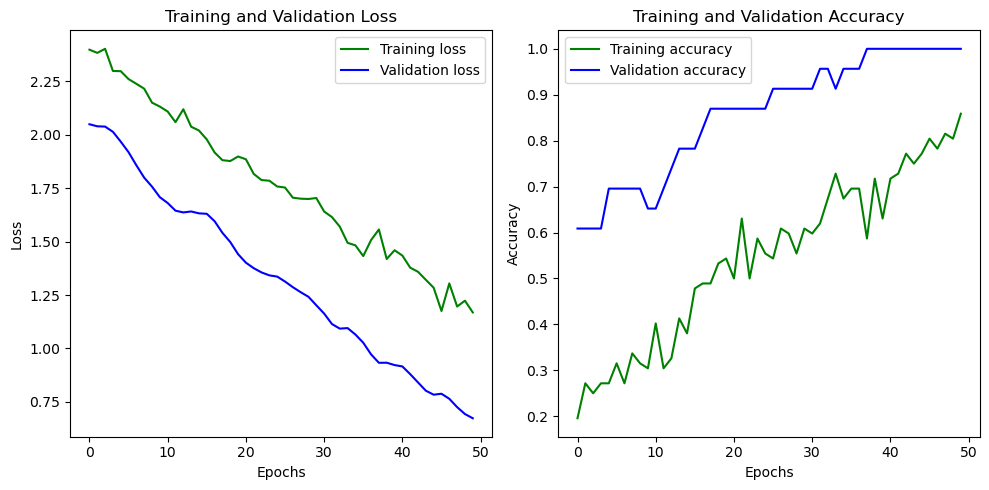

In [218]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, 'g', label='Training loss')
plt.plot(val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, 'g', label='Training accuracy')
plt.plot(val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [219]:
model.export(MODEL_DIR)

INFO:tensorflow:Assets written to: models/asl_words_classifier/assets


INFO:tensorflow:Assets written to: models/asl_words_classifier/assets


Saved artifact at 'models/asl_words_classifier/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 50, 2048), dtype=tf.float32, name='keras_tensor_997'), TensorSpec(shape=(None, 50), dtype=tf.bool, name='keras_tensor_998')]
Output Type:
  TensorSpec(shape=(None, 18), dtype=tf.float32, name=None)
Captures:
  21631955408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21631954832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21631958288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14695286544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21631955024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  21631956944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14695285776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14695287120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14695287312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14695287888: TensorSpec(shape=

In [223]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR) # path to the SavedModel directory
converter.experimental_enable_resource_variables = True
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Enable TensorFlow Lite ops
    tf.lite.OpsSet.SELECT_TF_OPS     # Enable TensorFlow ops
]
tflite_model = converter.convert()


# Save the model.
with open('models/asl_words_2_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

W0000 00:00:1725008541.887376   86912 tf_tfl_flatbuffer_helpers.cc:390] Ignored output_format.
W0000 00:00:1725008541.887387   86912 tf_tfl_flatbuffer_helpers.cc:393] Ignored drop_control_dependency.
2024-08-30 19:02:22.039047: W tensorflow/compiler/mlir/lite/flatbuffer_export.cc:2996] TFLite interpreter needs to link Flex delegate in order to run the model since it contains the following Select TFop(s):
Flex ops: FlexTensorListReserve, FlexTensorListSetItem, FlexTensorListStack
Details:
	tf.TensorListReserve(tensor<2xi32>, tensor<i32>) -> (tensor<!tf_type.variant<tensor<?x100xf32>>>) : {device = ""}
	tf.TensorListReserve(tensor<2xi32>, tensor<i32>) -> (tensor<!tf_type.variant<tensor<?x50xf32>>>) : {device = ""}
	tf.TensorListSetItem(tensor<!tf_type.variant<tensor<?x100xf32>>>, tensor<i32>, tensor<?x100xf32>) -> (tensor<!tf_type.variant<tensor<?x100xf32>>>) : {device = "", resize_if_index_out_of_bounds = false}
	tf.TensorListSetItem(tensor<!tf_type.variant<tensor<?x50xf32>>>, tensor<i3